✅ Total clauses: 150881
                                              clause  \
0  Absence of Certain Changes or Events. Except a...   
1  Absence of Certain Changes or Events. Since Ma...   
2  Absence of Certain Changes or Events. (a) Sinc...   
3  Absence of Certain Changes or Events. Since th...   
4  Absence of Certain Changes or Events. Except a...   

                               category  
0  absence-of-certain-changes-or-events  
1  absence-of-certain-changes-or-events  
2  absence-of-certain-changes-or-events  
3  absence-of-certain-changes-or-events  
4  absence-of-certain-changes-or-events  
✅ Total pairs generated: 79000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 64)        │  1,354,304 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,354,369 (5.17 MB)

 Trainable params: 1,354,369 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.7124 - loss: 0.4791 - val_accuracy: 0.7991 - val_loss: 0.3932
Epoch 2/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9388 - loss: 0.1789 - val_accuracy: 0.8823 - val_loss: 0.3604
Epoch 3/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9552 - loss: 0.1357 - val_accuracy: 0.8868 - val_loss: 0.3377
494/494 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

✅ Accuracy: 0.8893
✅ Precision: 0.9942
✅ Recall: 0.7832
✅ F1-score: 0.8762


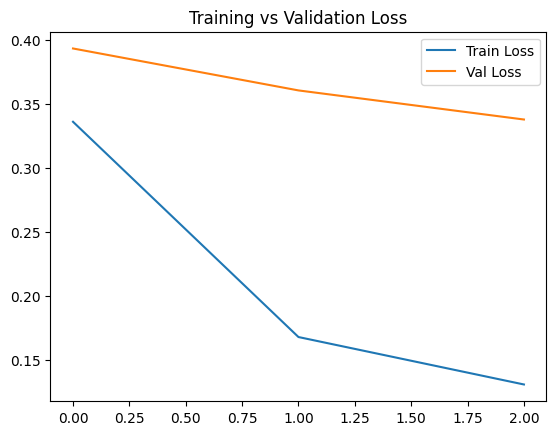

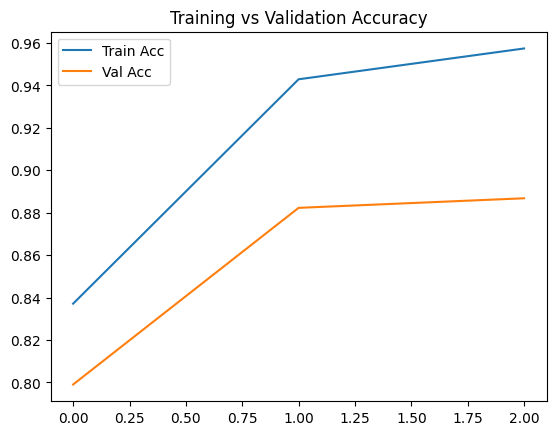

In [ ]:
import zipfile
import pandas as pd
import os
import random
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# ==============================
# Step 1: Read ZIP dataset
# ==============================
zip_path = r"archive.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    file_list = [f for f in z.namelist() if f.endswith('.csv')]
    df_list = []
    for file in file_list:
        with z.open(file) as f:
            df = pd.read_csv(f)
            cat = os.path.splitext(os.path.basename(file))[0]
            text_col = [c for c in df.columns if 'clause' in c.lower()]
            if text_col:
                text_col = text_col[0]
            else:
                text_col = df.columns[0]
            df = df[[text_col]].dropna()
            df.columns = ['clause']
            df['category'] = cat
            df_list.append(df)
    data = pd.concat(df_list, ignore_index=True)

print("✅ Total clauses:", len(data))
print(data.head())

# ==============================
# Step 2: Generate Fewer Pairs (for faster training)
# ==============================
def generate_pairs(df, n_pairs_per_cat=100, negative_ratio=1.0):
    cats = df['category'].unique()
    pos_pairs, neg_pairs = [], []
    for c in cats:
        items = df[df['category'] == c]['clause'].tolist()
        if len(items) < 2:
            continue
        combos = list(itertools.combinations(items, 2))
        random.shuffle(combos)
        for a, b in combos[:n_pairs_per_cat]:
            pos_pairs.append((a, b, 1))
    # Negative pairs
    all_items = df.groupby('category')['clause'].apply(list).to_dict()
    cats_list = list(all_items.keys())
    neg_count = int(len(pos_pairs) * negative_ratio)
    while len(neg_pairs) < neg_count:
        c1, c2 = random.sample(cats_list, 2)
        a = random.choice(all_items[c1])
        b = random.choice(all_items[c2])
        neg_pairs.append((a, b, 0))
    pairs = pos_pairs + neg_pairs
    random.shuffle(pairs)
    return pd.DataFrame(pairs, columns=['clause1', 'clause2', 'label'])

pairs = generate_pairs(data)
print("✅ Total pairs generated:", len(pairs))

# ==============================
# Step 3: Tokenization
# ==============================
MAX_NUM_WORDS = 20000
MAX_SEQ_LEN = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(pd.concat([pairs['clause1'], pairs['clause2']]))

def to_seq(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

a_seq = to_seq(pairs['clause1'])
b_seq = to_seq(pairs['clause2'])
y = np.array(pairs['label'])

X_train_a, X_test_a, X_train_b, X_test_b, y_train, y_test = train_test_split(
    a_seq, b_seq, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# Step 4: Define Siamese BiLSTM Model
# ==============================
def create_base_network(vocab_size, embed_dim=64):
    input_layer = Input(shape=(MAX_SEQ_LEN,))
    x = Embedding(vocab_size, embed_dim, input_length=MAX_SEQ_LEN)(input_layer)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    return Model(input_layer, x)

vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
base_network = create_base_network(vocab_size)

input_a = Input(shape=(MAX_SEQ_LEN,))
input_b = Input(shape=(MAX_SEQ_LEN,))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

L1_distance = Lambda(lambda x: K.abs(x[0] - x[1]))([processed_a, processed_b])
output = Dense(1, activation='sigmoid')(L1_distance)

model = Model([input_a, input_b], output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# ==============================
# Step 5: Train Model (small epochs first)
# ==============================
history = model.fit(
    [X_train_a, X_train_b], y_train,
    validation_split=0.2,
    epochs=3,         # can increase to 5-10 later
    batch_size=64,
    verbose=1
)

# ==============================
# Step 6: Evaluate Model
# ==============================
y_pred = (model.predict([X_test_a, X_test_b]) > 0.5).astype(int).ravel()

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n✅ Accuracy: {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall: {rec:.4f}")
print(f"✅ F1-score: {f1:.4f}")

# ==============================
# Step 7: Plot Training Graphs
# ==============================
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


✅ Total clauses: 150881
                                              clause  \
0  Absence of Certain Changes or Events. Except a...   
1  Absence of Certain Changes or Events. Since Ma...   
2  Absence of Certain Changes or Events. (a) Sinc...   
3  Absence of Certain Changes or Events. Since th...   
4  Absence of Certain Changes or Events. Except a...   

                               category  
0  absence-of-certain-changes-or-events  
1  absence-of-certain-changes-or-events  
2  absence-of-certain-changes-or-events  
3  absence-of-certain-changes-or-events  
4  absence-of-certain-changes-or-events  
✅ Total pairs generated: 79000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



🧠 Model 1: Siamese BiLSTM


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 64)        │  1,354,304 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,354,369 (5.17 MB)

 Trainable params: 1,354,369 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.6993 - loss: 0.5076 - val_accuracy: 0.8732 - val_loss: 0.3641
Epoch 2/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9240 - loss: 0.2160 - val_accuracy: 0.9248 - val_loss: 0.3281
Epoch 3/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9330 - loss: 0.1972 - val_accuracy: 0.9673 - val_loss: 0.2819

🧠 Model 2: Attention-Based Encoder


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 64)        │  1,354,532 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ functional_2[0][… │
│                     │                   │            │ functional_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,354,597 (5.17 MB)

 Trainable params: 1,354,597 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.5786 - loss: 0.6581 - val_accuracy: 0.6596 - val_loss: 0.5540
Epoch 2/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.7501 - loss: 0.4889 - val_accuracy: 0.6655 - val_loss: 0.5679
Epoch 3/3
790/790 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.7689 - loss: 0.4727 - val_accuracy: 0.8100 - val_loss: 0.4309
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

📊 Results for Siamese BiLSTM:
Accuracy : 0.9685
Precision: 0.9735
Recall   : 0.9633
F1-score : 0.9684
ROC-AUC  : 0.9886
494/494 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

📊 Results for Attention Encoder:
Accuracy : 0.8037
Precision: 0.8607
Recall   : 0.7248
F1-score : 0.7869
ROC-AUC  : 0.9123

🏁 MODEL PERFORMANCE COMPARISON
               Model  Accuracy  Precision    Recall        F1       AUC
0     Siamese BiLSTM  0.968544   0.973519  0.963291  0.968378  0.988557
1  Attention Encoder  0.803734   0.860664  0.724810  0.786917  0.912301


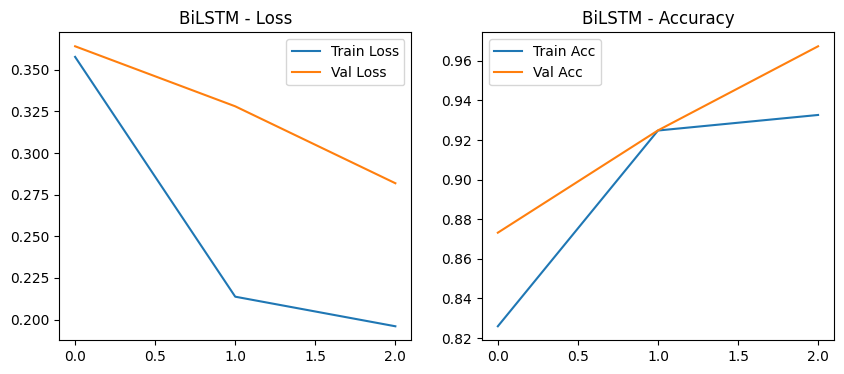

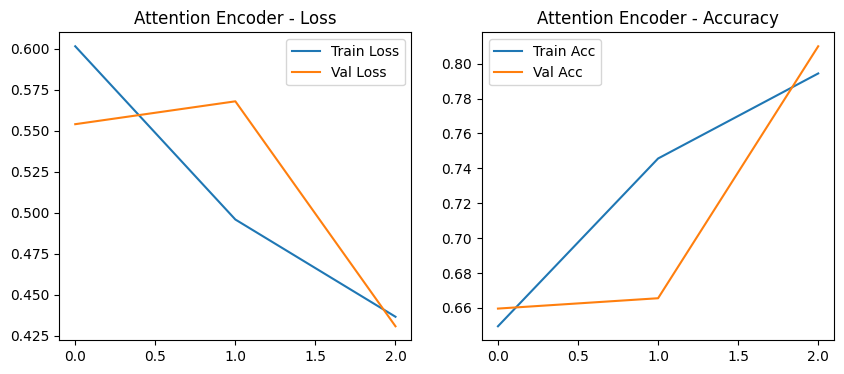


✅ Results saved as 'model_comparison_results.csv'


In [ ]:
import zipfile
import pandas as pd
import os
import random
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# ==============================
# Step 1: Read ZIP dataset
# ==============================
zip_path = r"archive.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    file_list = [f for f in z.namelist() if f.endswith('.csv')]
    df_list = []
    for file in file_list:
        with z.open(file) as f:
            df = pd.read_csv(f)
            cat = os.path.splitext(os.path.basename(file))[0]
            text_col = [c for c in df.columns if 'clause' in c.lower()]
            if text_col:
                text_col = text_col[0]
            else:
                text_col = df.columns[0]
            df = df[[text_col]].dropna()
            df.columns = ['clause']
            df['category'] = cat
            df_list.append(df)
    data = pd.concat(df_list, ignore_index=True)

print("✅ Total clauses:", len(data))
print(data.head())

# ==============================
# Step 2: Generate Fewer Pairs
# ==============================
def generate_pairs(df, n_pairs_per_cat=100, negative_ratio=1.0):
    cats = df['category'].unique()
    pos_pairs, neg_pairs = [], []
    for c in cats:
        items = df[df['category'] == c]['clause'].tolist()
        if len(items) < 2:
            continue
        combos = list(itertools.combinations(items, 2))
        random.shuffle(combos)
        for a, b in combos[:n_pairs_per_cat]:
            pos_pairs.append((a, b, 1))
    all_items = df.groupby('category')['clause'].apply(list).to_dict()
    cats_list = list(all_items.keys())
    neg_count = int(len(pos_pairs) * negative_ratio)
    while len(neg_pairs) < neg_count:
        c1, c2 = random.sample(cats_list, 2)
        a = random.choice(all_items[c1])
        b = random.choice(all_items[c2])
        neg_pairs.append((a, b, 0))
    pairs = pos_pairs + neg_pairs
    random.shuffle(pairs)
    return pd.DataFrame(pairs, columns=['clause1', 'clause2', 'label'])

pairs = generate_pairs(data)
print("✅ Total pairs generated:", len(pairs))

# ==============================
# Step 3: Tokenization
# ==============================
MAX_NUM_WORDS = 20000
MAX_SEQ_LEN = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(pd.concat([pairs['clause1'], pairs['clause2']]))

def to_seq(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

a_seq = to_seq(pairs['clause1'])
b_seq = to_seq(pairs['clause2'])
y = np.array(pairs['label'])

X_train_a, X_test_a, X_train_b, X_test_b, y_train, y_test = train_test_split(
    a_seq, b_seq, y, test_size=0.2, random_state=42, stratify=y
)

vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)

# ===================================================
# Step 4A: Model 1 — Siamese BiLSTM (Baseline)
# ===================================================
def create_base_network(vocab_size, embed_dim=64):
    input_layer = Input(shape=(MAX_SEQ_LEN,))
    x = Embedding(vocab_size, embed_dim, input_length=MAX_SEQ_LEN)(input_layer)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    return Model(input_layer, x)

base_network = create_base_network(vocab_size)

input_a = Input(shape=(MAX_SEQ_LEN,))
input_b = Input(shape=(MAX_SEQ_LEN,))
processed_a = base_network(input_a)
processed_b = base_network(input_b)
L1_distance = Lambda(lambda x: K.abs(x[0] - x[1]))([processed_a, processed_b])
output = Dense(1, activation='sigmoid')(L1_distance)

model_lstm = Model([input_a, input_b], output)
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\n============================")
print("🧠 Model 1: Siamese BiLSTM")
print("============================")
model_lstm.summary()

history_lstm = model_lstm.fit(
    [X_train_a, X_train_b], y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=64,
    verbose=1
)

# ===================================================
# Step 4B: Model 2 — Attention-Based Encoder
# ===================================================
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    """Custom Attention Layer"""
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

def create_attention_model(vocab_size, embed_dim=64):
    input_layer = Input(shape=(MAX_SEQ_LEN,))
    x = Embedding(vocab_size, embed_dim)(input_layer)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = AttentionLayer()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    return Model(input_layer, x)

att_base = create_attention_model(vocab_size)

input1 = Input(shape=(MAX_SEQ_LEN,))
input2 = Input(shape=(MAX_SEQ_LEN,))
enc1 = att_base(input1)
enc2 = att_base(input2)
L1 = Lambda(lambda x: K.abs(x[0] - x[1]))([enc1, enc2])
output2 = Dense(1, activation='sigmoid')(L1)

model_att = Model([input1, input2], output2)
model_att.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\n============================")
print("🧠 Model 2: Attention-Based Encoder")
print("============================")
model_att.summary()

history_att = model_att.fit(
    [X_train_a, X_train_b], y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=64,
    verbose=1
)

# ===================================================
# Step 5: Evaluation Function for Both Models
# ===================================================
def evaluate_model(model, name):
    y_pred = model.predict([X_test_a, X_test_b])
    y_pred_class = (y_pred > 0.5).astype(int).ravel()
    acc = accuracy_score(y_test, y_pred_class)
    prec = precision_score(y_test, y_pred_class)
    rec = recall_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    auc = roc_auc_score(y_test, y_pred)
    print(f"\n📊 Results for {name}:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc}

results_lstm = evaluate_model(model_lstm, "Siamese BiLSTM")
results_att = evaluate_model(model_att, "Attention Encoder")

# ===================================================
# Step 6: Compare Both Models
# ===================================================
results_df = pd.DataFrame([results_lstm, results_att])
print("\n===============================")
print("🏁 MODEL PERFORMANCE COMPARISON")
print("===============================")
print(results_df)

# ===================================================
# Step 7: Plot Training Graphs
# ===================================================
def plot_history(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

plot_history(history_lstm, "BiLSTM")
plot_history(history_att, "Attention Encoder")

# ===================================================
# Step 8: Save Model Results for Report
# ===================================================
results_df.to_csv("model_comparison_results.csv", index=False)
print("\n✅ Results saved as 'model_comparison_results.csv'")
